In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys, time, os, math
import string
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import trajCellPoseSr as cellTraj
import h5py
import scipy
import subprocess
import umap
#from deeptime.clustering import KMeans
from csaps import csaps
from joblib import dump, load
from datetime import date

In [2]:
# Trajectory Length for morphodynamical trajectory analysis
trajl = 40
#trajl = int(sys.argv[1])
#if trajl is None:
#  print("Enter trajectory snippet length for morphodynamical analysis")
#  sys.exit(0)

#os.environ['OMP_NUM_THREADS'] = '1'; os.environ['MKL_NUM_THREADS'] = '1'

today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = sysName+'_tlen'+str(trajl)+'_'+date2day
conditions = ['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3'] # LIGANDS (CONDITIONS)
tmSet = ['OSM1','EGF1','EGF+TGFB1','TGFB1','PBS1','OSM2','EGF2','EGF+TGFB2','TGFB2','PBS2',
         'OSM+EGF+TGFB','OSM+EGF','OSM+TGFB']
nRepConds = 5 # Number of models (conditions) that are replicas 
nConditions = len(tmSet) # Total number of Ligand Conditions
# Indices for the ligands = 13
inds_tmSet = [i for i in range(nConditions)]
inds_tmSet = np.array(inds_tmSet).astype(int)
nfovs = 4
fovs = [i for i in range(1, nfovs + 1)]
fovs = np.array(fovs).astype(int)
dateSet = ['']
pathSet = ['/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/dynaMorph/']
imagingSet = [0 for i in range(nConditions)]
modelList = [None]*(nfovs*(nConditions))
modelList_conditions = np.zeros(nfovs*(nConditions)).astype(int)

In [3]:
i = 0
icond = 0
for cond in conditions:
    for fov in fovs:
        modelList_conditions[i] = icond
        modelName = sysName+'_'+cond+'_'+str(fov)
        # Get the name of .obj file as a "string", including its path
        modelList[i] = pathSet[imagingSet[icond]]+modelName+dateSet[imagingSet[icond]]
        #print("Model names = ", modelList[i])
        i = i + 1
    icond = icond + 1

nmodels = int(i)
indgood_models = np.array([]).astype(int)
model_objects = {}

In [ ]:
for i in range(nmodels):
    try:
        objFile = modelList[i]+'.joblib'
        with open(objFile, 'rb') as fp:
            # Load objects from the file 
            linSet, Xf, Xf_com, cells_frameSet, cells_indSet, Trajectories, cells_imgfileSet, cells_indcmskSet  = load(fp)
            # Assign objects of each model separately to call later by index "i" and object name
            model_objects[i] = {'linSet': linSet,
                                'Xf': Xf,
                                'Xf_com': Xf_com,
                                'cells_frameSet': cells_frameSet,
                                'cells_indSet': cells_indSet,
                                'Trajectories': Trajectories,
                                'cells_imgfileSet': cells_imgfileSet,
                                'cells_indcmskSet': cells_indcmskSet}
            print('loaded '+'.../'+objFile[32:]+' with '+str(model_objects[i]['cells_indSet'].size)+' cells')
            test = len(model_objects[i]['linSet'])
            indgood_models = np.append(indgood_models, i)
    except:
        print("Error in reading data from .joblib files")
        pass

In [5]:
nframes = 193 # 193 Frames -->  each of 15 mins = 48 hrs
# Create arrays for (TIFF) image files and frames (dumped @ 15 minutes) 
imgfileList = np.array([])
imgfileList = np.append(imgfileList, 0)
start_frame = 0
end_frame = nframes
imgfileSet = imgfileList.copy()
frameSet = start_frame*np.ones_like(imgfileSet)
for i in range(start_frame+1, end_frame+1):
    imgfileSet = np.append(imgfileSet, imgfileList)
    frameSet = np.append(frameSet, i*np.ones_like(imgfileList))

imgfileSet = imgfileSet.astype(int)
frameSet = frameSet.astype(int)
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*nframes/100.; sframe = math.ceil(sframe)
eframe = 98.5*nframes/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(nframes)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

In [6]:
#plt.clf()
#plt.figure(figsize = (8, 7))

with open('cellNumbers.dat', 'w', encoding = 'utf-8') as fp: # PRINT cell numbers in a file for each model
    for i in indgood_models:
        ncells = np.zeros(nframes)
        ncells_smooth = np.zeros_like(ncells)
        cell_indCmskSet = np.array([]) # Array of masked cell indices
        for iS in range(nframes):
            ncells[iS] = np.sum(model_objects[i]['cells_frameSet'] == iS)
            cell_indCmskSet = np.append(cell_indCmskSet, iS*np.ones(int(ncells[iS])))
            fp.write(str(ncells[iS])+"\t")
        fp.write("\n")
        cell_indCmskSet = cell_indCmskSet.astype(int)
        model_objects[i]['cells_indcmskSet'] = cell_indCmskSet
        model_objects[i]['cells_imgfileSet'] = cell_indCmskSet
        #print("Shape of cell masks indices =", model_objects[i]['cells_indcmskSet'].shape)
        # Cubic Spline Approximation (CSAPS) to smoothen the data
        splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
        ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
        cellnumber_std = np.std(ncells[cellnumber_frames] 
                                - ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
        cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers
        #print("cellnumber_stdSet[",i,"] = ", cellnumber_std)
        # Plot number of normalized number of cells vs frame number for each Model
        #plt.plot(ncells/ncells[0], color = colModels[i], label = capModels[i]);
        #plt.plot(ncells, color = colModels[i], label = capModels[i]);plt.pause(.5) 
        #plt.plot(ncells/ncells[0]); plt.pause(.5) 

#plt.xlabel('Frame Number')
#plt.ylabel('Normalized Cell Numbers')
#plt.legend(loc='best')
#plt.tight_layout()
#plt.savefig('cellNumbers_'+figid+'.png')

In [7]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)
#print("Indices of high SD models = ", indhigh_std); print("Indices of good models = ", indgood_models); sys.exit(0)
print("Number of Good Models = ", len(indgood_models))

num_trajModSet = len(tmSet) # Total number of trajectory (models) conditions including replicas
inds_tmSet_models = np.zeros(nmodels).astype(int)
inds_imagingSet_models = np.zeros(nmodels).astype(int)
i = 0
icond = 0
for cond in conditions:
    for fov in fovs:
        inds_tmSet_models[i] = inds_tmSet[icond]
        inds_imagingSet_models[i] = imagingSet[icond]
        i = i + 1
    icond = icond + 1

# just replace with zeros for now? Not sure best..
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        model_objects[i]['Xf'][np.isnan(model_objects[i]['Xf'])] = 0.0

nfeat_com = 3
Xf_com0 = np.zeros((0, nfeat_com))
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf_com0 = np.append(Xf_com0, model_objects[i]['Xf_com'], axis=0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    model_objects[i]['Xf_com'][:, 0] = (model_objects[i]['Xf_com'][:, 0] - av_dx)/std_dx

nfeat = model_objects[indgood_models[0]]['Xf'].shape[1]
Xf0 = np.zeros((0, nfeat))
indtreatment = np.array([])
indcellSet = np.array([])
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf0 = np.append(Xf0, model_objects[i]['Xf'], axis=0)
        indtreatment = np.append(indtreatment, i*np.ones(model_objects[i]['Xf'].shape[0]))
        indcellSet = np.append(indcellSet, model_objects[i]['cells_indSet'])

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

Number of Good Models =  52


In [8]:
# we will use the sklearn package (intended for ease of use over performance/scalability)
from sklearn.decomposition import PCA 
# n_components specifies the number of principal components to extract from the covariance matrix
#pca = PCA(n_components = 3)
varCutOff = 0.99
#@@@@@@ Variance Cut Offs and their corresponding features after dimensional reduction using PCA @@@@@@
#varCutOffs = [0.95, 0.96, 0.97, 0.98, 0.985, 0.99, 0.992, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999]
#nFeatures = [5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 20, 27]
#for varCutOff in varCutOffs:
pca = PCA(n_components = varCutOff)
# builds the covariance matrix, fit the PCs, and transforms the data into the PCA representation
Xpca = pca.fit_transform(Xf0) 
print("Number of cell features used after dimensional reduction: ",Xpca.shape[1])

Number of cell features used after dimensional reduction:  10


In [9]:
wctm = cellTraj.cellPoseTraj()  
wctm.Xpca = Xpca

for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        indsf = np.where(indtreatment == i)[0]
        model_objects[i]['Xpca'] = Xpca[indsf, :]

indgood_models = indgood_models[np.where(inds_imagingSet_models[indgood_models] == 0)[0]]

In [ ]:
self = wctm
wctm.trajl = trajl
self.imgfileSet = imgfileSet
self.frameSet = frameSet
all_trajSet = [None]*nmodels
cells_indcmskSet = []
for i in indgood_models:
    self.trajectories = model_objects[i]['Trajectories']
    self.cells_imgfileSet = model_objects[i]['cells_imgfileSet']
    self.cells_frameSet = model_objects[i]['cells_frameSet']
    self.cells_indSet = model_objects[i]['cells_indSet']
    self.cells_indcmskSet = model_objects[i]['cells_indcmskSet']
    self.linSet = model_objects[i]['linSet']
    print("Tracking cell trajectories of model: ",i)
    self.get_unique_trajectories() # Due to embedded trajectories 
    all_trajSet[i] = self.trajectories.copy()

In [ ]:
# Storing PCA'ed features at a desired trajectory snippet length, i.e., "trajl"
Xpcat = np.zeros((0, pca.n_components_*trajl + nfeat_com*trajl))
indtreatment_traj = np.array([])
indstack_traj = np.array([])
indframes_traj = np.array([])
cellinds0_traj = np.array([])
cellinds1_traj = np.array([])
cb_ratio_traj = np.array([])
for i in indgood_models:
    print("building trajectory data for model", i ,"...")
    self.trajectories = all_trajSet[i].copy()
    model_objects[i]['Trajectories'] = self.trajectories
    model_objects[i]['trajl'] = trajl
    model_objects[i]['traj'] = self.get_traj_segments(trajl) 
    data = model_objects[i]['Xpca'][model_objects[i]['traj'], :]
    datacom = model_objects[i]['Xf_com'][model_objects[i]['traj'], :]
    data = data.reshape(model_objects[i]['traj'].shape[0], model_objects[i]['Xpca'].shape[1]*trajl)
    datacom = datacom.reshape(model_objects[i]['traj'].shape[0], model_objects[i]['Xf_com'].shape[1]*trajl)
    data = np.append(data, datacom, axis=1)
    indgood = np.where(np.sum(np.isnan(data), axis=1) == 0)[0]
    data = data[indgood, :]
    model_objects[i]['traj'] = model_objects[i]['traj'][indgood, :]
    Xpcat = np.append(Xpcat, data, axis = 0)
    indtreatment_traj = np.append(indtreatment_traj, i*np.ones(data.shape[0]))
    indstacks = model_objects[i]['cells_imgfileSet'][model_objects[i]['traj'][:, 0]]
    indstack_traj = np.append(indstack_traj, indstacks)
    indframes = model_objects[i]['cells_frameSet'][model_objects[i]['traj'][:, 0]]
    indframes_traj = np.append(indframes_traj, indframes)
    cellinds0 = model_objects[i]['traj'][:, 0]
    cellinds0_traj = np.append(cellinds0_traj, cellinds0)
    cellinds1 = model_objects[i]['traj'][:, -1]
    cellinds1_traj = np.append(cellinds1_traj, cellinds1)
    cb_ratio_traj = np.append(cb_ratio_traj, model_objects[i]['Xf'][cellinds1, 77])

cellinds0_traj = cellinds0_traj.astype(int)
cellinds1_traj = cellinds1_traj.astype(int)
#print("Shape of Xpcat: ",Xpcat.shape)

In [12]:
# Apply UMAP on PCA'ed features of cell trajectories
get_embedding = True
neigen_umap = 2
if get_embedding:
    reducer = umap.UMAP(n_neighbors = 200, min_dist = 0.1,
                        n_components = neigen_umap, metric = 'euclidean')
    trans = reducer.fit(Xpcat)
    embedTraj_feat = trans.embedding_
    indst = np.arange(embedTraj_feat.shape[0]).astype(int)
    wctm.Xtraj = embedTraj_feat.copy()
    wctm.indst = indst.copy()
    dump(embedTraj_feat, sysName+'_trajl'+str(trajl)+'_d2embedding_'+date2day+'.joblib')
else:
    embedTraj_feat = load(sysName+'_trajl'+str(trajl)+'_d2embedding_'+date2day+'.joblib')

print("Applied UMAP for dimensional reduction @ 2D on trajectory embedding data")

Applied UMAP for dimensional reduction @ 2D on trajectory embedding data


In [13]:
inds_conditions = [None]*num_trajModSet
for imf in range(num_trajModSet):
    indmodels = np.intersect1d(indgood_models, np.where(inds_tmSet_models == imf)[0])
    indstm = np.array([])
    for imodel in indmodels:
        indtm = np.where(indtreatment_traj == imodel)
        indstm = np.append(indstm, indtm)
    inds_conditions[imf] = indstm.astype(int).copy()

In [14]:
################ Clustering using KMeans from sklearn OR deeptime OR pyemma.coordinates #################
#Xpcat_ = Xpcat.copy()
n_clusters = 200
# cluster trajectories and store in 'clusters' that have attributes like cluster_centers_, inertia, ...
from sklearn.cluster import KMeans
#clusters_skl = KMeans(n_clusters = n_clusters, init='k-means++',
#                      max_iter = 1000, random_state = 0).fit(Xpcat_)
#centers_skl = clusters_skl.cluster_centers_

import pyemma.coordinates as coor
#clusters = coor.cluster_kmeans(embedTraj_feat, k = n_clusters, metric = 'euclidean',
clusters = coor.cluster_kmeans(Xpcat, k = n_clusters, metric = 'euclidean',
                               init_strategy = 'kmeans++', max_iter = 1000)
#                               clustercenters = centers_skl, keep_data = True)
# Using cluster centers from sklearn's KMeans 
wctm.clusterst = clusters 
print("Clustering of embedded trajectories is Done!")
neigen = Xpcat.shape[1] # When using the PCA'ed featured trajectories
#neigen = embedTraj_feat.shape[1] # When using UMAP'ed after PCA'ed features

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|          | 0/200 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Clustering of embedded trajectories is Done!


In [ ]:
######################## Get Single Cell Trajectory Segments  #########################
knn = 50
dxs = np.zeros((nmodels, n_clusters, neigen))
x0set = np.zeros((0, neigen))
x1set = np.zeros((0, neigen))
inds_trajsteps_models = np.array([]).astype(int)
nlag = 1 # Lag between two trajectory segments 

for i in indgood_models:
    print('getting flows from model: '+str(i))
    indstm = np.where(indtreatment_traj == i)[0]
    if indstm.size > 0:
        #embedTraj = embedTraj_feat[indstm, 0:neigen]
        embedTraj = Xpcat[indstm, 0:neigen]
        model_objects[i]['Xtraj'] = embedTraj
        indstm_model = indstm - np.min(indstm) #index in model
        traj = model_objects[i]['traj'][indstm_model, :]
        Xtraj = model_objects[i]['Xtraj'][indstm_model, :]
        # nlag = 1 --> trajectories are recorded at same time step, i.e., @ 15 mins in this Dataset
        self.trajectories = model_objects[i]['Trajectories']
        self.cells_imgfileSet = model_objects[i]['cells_imgfileSet']
        self.cells_frameSet = model_objects[i]['cells_frameSet']
        self.cells_indSet = model_objects[i]['cells_indSet']
        self.cells_indcmskSet = model_objects[i]['cells_indcmskSet']
        self.linSet = model_objects[i]['linSet']
        inds_model = np.arange(self.cells_indSet.size).astype(int)
        inds = inds_model
        get_trajectories = False
        if get_trajectories:
            self.get_unique_trajectories(cell_inds = inds, verbose = False)
        trajp1 = self.get_traj_segments(self.trajl + nlag)
        inds_nlag = np.flipud(np.arange(self.trajl + nlag - 1, -1, -nlag)).astype(int) # keep indices every nlag
        trajp1 = trajp1[:, inds_nlag]
        ntraj = trajp1.shape[0]
        #neigen = embedTraj_feat.shape[1]
        neigen = Xpcat.shape[1]
        x0 = np.zeros((0, neigen))
        x1 = np.zeros((0, neigen))
        inds_trajp1 = np.zeros((0, 2)).astype(int)
        for itraj in range(ntraj):
            test0 = trajp1[itraj, 0:-1]
            test1 = trajp1[itraj, 1:]
            res0 = (traj[:, None] == test0[np.newaxis, :]).all(-1).any(-1)
            res1 = (traj[:, None] == test1[np.newaxis, :]).all(-1).any(-1)
            if (np.sum(res0) == 1) and (np.sum(res1) == 1):
                indt0 = np.where(res0)[0][0]
                indt1 = np.where(res1)[0][0]
                #x0 = np.append(x0, np.array([embedTraj_feat[indt0, :]]), axis=0)
                #x1 = np.append(x1, np.array([embedTraj_feat[indt1, :]]), axis=0)
                x0 = np.append(x0, np.array([Xpcat[indt0, :]]), axis=0)
                x1 = np.append(x1, np.array([Xpcat[indt1, :]]), axis=0)
                inds_trajp1 = np.append(inds_trajp1, np.array([[indt0, indt1]]), axis=0)
            if itraj%100 == 0:
                sys.stdout.write('matching up trajectory '+str(itraj)+'\n')
        
        model_objects[i]['Xtraj0'] = x0
        model_objects[i]['Xtraj1'] = x1
        model_objects[i]['inds_trajp1'] = inds_trajp1
        x0set = np.append(x0set, x0, axis=0)
        x1set = np.append(x1set, x1, axis=0)
        inds_trajsteps_models = np.append(inds_trajsteps_models, np.ones(x0.shape[0])*i)
        dx = x1 - x0 # Measure the difference in morphological properties at two different times
        #print("No of trajectories in model ",i,"are ",ntraj, "shape of dx for model ",i,"is ",dx.shape)
        for iclust in range(n_clusters):
            xc = np.array([clusters.clustercenters[iclust, :]])
            #################### Get Density matrix ####################
            ind_trajectory = model_objects[i]['inds_trajp1'][:, -1] # 
            xc_0 = model_objects[i]['Xtraj'][ind_trajectory, :] 
            dmatr = wctm.get_dmat(xc_0, xc) #get closest cells to cluster center
            indr = np.argsort(dmatr[:, 0])
            indr = indr[0:knn]
            cell_inds_t = model_objects[i]['inds_trajp1'][indr, -1]
            cellindsr = model_objects[i]['traj'][cell_inds_t, -1]
            dxs[i, iclust, :] = np.mean(dx[indr, :], axis=0)
dxsav = np.mean(dxs, axis=0) 
######################## End Single Cell Trajectory Segments  #########################

In [16]:
# Get cumulative distribution of UMAP'ed trajectories 
def get_cdist2d(prob1):
    nx = prob1.shape[0]
    ny = prob1.shape[1]
    prob1 = prob1/np.sum(prob1)
    prob1 = prob1.flatten()
    indprob1 = np.argsort(prob1)
    probc1 = np.zeros_like(prob1)
    probc1[indprob1] = np.cumsum(prob1[indprob1])
    probc1 = 1. - probc1
    probc1 = probc1.reshape((nx, ny))
    return probc1

def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [17]:
nbins = 20
# Frames for a time window, where each frame is dumped @ 15 minutes
fl = 0
#fu = 144 # 36 hrs
fu = nframes  

indtreatment_traj = indtreatment_traj.astype(int)
inds_imagingSet_traj = inds_imagingSet_models[indtreatment_traj]

indstw = np.where(np.logical_and(indframes_traj < fu, indframes_traj > fl))[0]
indscc = np.where(cb_ratio_traj < np.inf)[0]
indstw = np.intersect1d(indstw, indscc)

In [18]:
#*** Compute Transition matrix between micro-clusters & build Markov Model ***!
centers_minima = clusters.clustercenters.copy()
# Add assign attribute to find clusters' indices later
clusters_minima = coor.clustering.AssignCenters(centers_minima, metric = 'euclidean')
# Compute transition matrix between the cluster centers
wctm.get_transition_matrix(x0set, x1set, clusters = clusters_minima)
P = wctm.Mt.copy() # Copy Transition Matrix 'Mt' from wctm
print("Shape of transition matrix before cleaning up =", P.shape)

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

graph = csr_matrix(P > 0.)
n_components, labels = connected_components(csgraph = graph, directed = False, return_labels = True)
unique, counts = np.unique(labels, return_counts = True)
icc = unique[np.argmax(counts)]
indcc = np.where(labels == icc)[0]

centers_minima = centers_minima[indcc, :]
clusters_minima = coor.clustering.AssignCenters(centers_minima, metric = 'euclidean')

wctm.get_transition_matrix(x0set, x1set, clusters = clusters_minima)
P = wctm.Mt.copy() # Transition Matrix
print("Shape of transition matrix after removing disconnected micro-states =", P.shape)

# Generalized Perron-Cluster Cluster Analysis (GPCCA) to coarse-grain reversible and non-reversible MSMs
import pygpcca as gp
# copy original clustered single cell trajectories
gpcca = gp.GPCCA(P, eta=None, z='LM', method='brandts')

# Dump Transition Matrix for further analysis 
tmFileName = 'transitionMatrix_'+sysName+'_'+str(trajl)+'_'+date2day+'.joblib'
with open(tmFileName, 'wb') as fp:
    dump(P, fp, compress = 'zlib')

Shape of transition matrix before cleaning up = (200, 200)
Shape of transition matrix after removing disconnected micro-states = (169, 169)


In [19]:
# Find Eigen Values and Eigen vectors of the transition matrix "P"
H = .5*(P + np.transpose(P)) + .5j*(P - np.transpose(P))
w, v = np.linalg.eig(H)  
w = np.real(w)
indsort = np.argsort(w)
w = w[indsort] # Eigen Values
v = v[:, indsort] # Eigen Vectors
ncomp = 20 # Keep last "ncomp" eigen vectors
vr = np.multiply(w[-ncomp:], np.real(v[:, -ncomp:]))
vi = np.multiply(w[-ncomp:], np.imag(v[:, -ncomp:]))
vkin = np.append(vr, vi, axis = 1)
#plt.plot(w)

In [20]:
from sklearn.cluster import KMeans
def get_kinetic_states(self, vkin, nstates_final, nstates_initial = None, pcut_final = .01,
                       max_states = 20, cluster_ninit = 10):
    if nstates_initial is None:
        nstates_initial = nstates_final
    nstates_good = 0
    nstates = nstates_initial
    while nstates_good < nstates_final and nstates < max_states:
        clusters_v = KMeans(n_clusters = nstates, init = 'k-means++',
                            n_init = cluster_ninit, max_iter = 1000, 
                            random_state = 0)
        clusters_v.fit(vkin)
        stateSet = clusters_v.labels_
        state_probs = np.zeros(nstates)
        statesc,counts = np.unique(stateSet, return_counts = True)
        state_probs[statesc] = counts/np.sum(counts)
        print(np.sort(state_probs))
        nstates_good = np.sum(state_probs > pcut_final)
        print('{} states initial, {} states final'.format(nstates, nstates_good))
        print(nstates, "Current states", nstates_good, "Good states")
        nstates = nstates + 1
    pcut = np.sort(state_probs)[-(nstates_final)] #nstates
    states_plow = np.where(state_probs < pcut)[0]
    # Get rid of the states with probabilities less than 'pcut'
    for i in states_plow:
        indstate = np.where(stateSet == i)[0]
        for imin in indstate:
            dists = wctm.get_dmat(np.array([vkin[imin, :]]), vkin)[0] #closest in eigen space
            dists[indstate] = np.inf
            ireplace = np.argmin(dists)
            stateSet[imin] = stateSet[ireplace]
    slabels, counts = np.unique(stateSet, return_counts = True)
    s = 0
    stateSet_clean = np.zeros_like(stateSet)
    for slabel in slabels:
        indstate = np.where(stateSet == slabel)[0]
        stateSet_clean[indstate] = s
        s = s + 1
    stateSet = stateSet_clean
    if np.max(stateSet) > nstates_final:
        print(f'returning {np.max(stateSet)} states, {nstates_final} requested')
        print("returning ", np.max(stateSet)," states", nstates_final, "requested")
        
    return stateSet, nstates

In [52]:
nstates_final = 14
max_states = 100
stateSet, nstates = get_kinetic_states(wctm, vkin, nstates_final,
                                       nstates_initial = None, pcut_final = .025, 
                                       max_states = max_states, cluster_ninit = 10)
stateCenters = clusters_minima.clustercenters
# NOTE: pcut_final = 0.2 - 0.25 makes better homogeneous state space occupation, though vary with nstates
# pcut_final=0.025--> nstates_final=7

[0.00591716 0.01183432 0.01183432 0.01183432 0.01183432 0.01183432
 0.01775148 0.01775148 0.01775148 0.01775148 0.01775148 0.02366864
 0.34911243 0.47337278]
14 states initial, 2 states final
14 Current states 2 Good states
[0.00591716 0.01183432 0.01183432 0.01183432 0.01183432 0.01183432
 0.01775148 0.01775148 0.01775148 0.01775148 0.01775148 0.02366864
 0.02366864 0.31952663 0.47928994]
15 states initial, 2 states final
15 Current states 2 Good states
[0.00591716 0.01183432 0.01183432 0.01183432 0.01183432 0.01183432
 0.01183432 0.01775148 0.01775148 0.01775148 0.01775148 0.01775148
 0.02366864 0.02366864 0.31360947 0.47337278]
16 states initial, 2 states final
16 Current states 2 Good states
[0.00591716 0.01183432 0.01183432 0.01183432 0.01183432 0.01183432
 0.01183432 0.01183432 0.01775148 0.01775148 0.01775148 0.01775148
 0.02366864 0.08284024 0.13609467 0.26035503 0.33727811]
17 states initial, 4 states final
17 Current states 4 Good states
[0.00591716 0.00591716 0.00591716 0.00

[0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.01183432 0.01183432 0.01183432 0.01183432 0.01183432
 0.01183432 0.01183432 0.01183432 0.01183432 0.01183432 0.01775148
 0.01775148 0.01775148 0.01775148 0.02366864 0.02366864 0.0887574
 0.13609467 0.15976331 0.26627219]
39 states initial, 4 states final
39 Current states 4 Good states
[0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.01183432
 0.01183432 0.01183432 0.01183432 0.01183432 0.01183432 0.01775148
 0.01775148 0.01775148 0.01775148 0.01775148 0.02366864 0.02366864
 0.12426036 0.15976331 0.17159763 0.20118343]
40 states initial, 4 states final
40 Current state

[0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.01183432 0.01183432 0.01183432
 0.01183432 0.01183432 0.01775148 0.01775148 0.01775148 0.01775148
 0.02366864 0.05325444 0.06508876 0.07100592 0.0887574  0.13609467
 0.20118343]
55 states initial, 6 states final
55 Current states 6 Good states
[0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.005

[0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.01183432 0.01183432 0.01183432
 0.01183432 0.01183432 0.01183432 0.01183432 0.01775148 0.01775148
 0.0295858  0.03550296 0.06508876 0.07100592 0.11242604 0.13017751
 0.13609467]
67 states initial, 7 states final
67 Current states 7 Good states
[0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.005

[0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.01183432
 0.01183432 0.01183432 0.01183432 0.01183432 0.01183432 0.01183432
 0.01183432 0.01775148 0.01775148 0.01775148 0.02366864 0.05325444
 0.06508876 0.06508876 0.07100592 0.0887574  0.13609467]
77 states initial, 6 states final
77 Current states 6 Good states
[0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.005

[0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.01183432 0.01183432 0.01183432 0.01183432 0.01183432 0.01183432
 0.01775148 0.01775148 0.0591716  0.06508876 0.06508876 0.07100592
 0.07692308 0.13017751]
86 states initial, 6 states final
86 C

[0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716 0.00591716
 0.00591716 0.00591716 0.00591716 0.00591716 0.01183432 0.01183432
 0.01183432 0.01183432 0.01183432 0.01183432 0.01183432 0.01183432
 0.01775148 0.01775148 0.0295858  0.0295858  0.03550296 0.0473

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/trajCellPoseSr.py:2298: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)


In [50]:
nstates = np.unique(stateSet).size
n_states = nstates
state_centers_minima = np.zeros((n_states, neigen))
for i in range(n_states):
    indstate = np.where(stateSet == i)[0]
    state_centers_minima[i, :] = np.median(stateCenters[indstate, :], axis=0)

state_labels = np.array(list(string.ascii_uppercase))[0:nstates]

<Figure size 640x480 with 0 Axes>

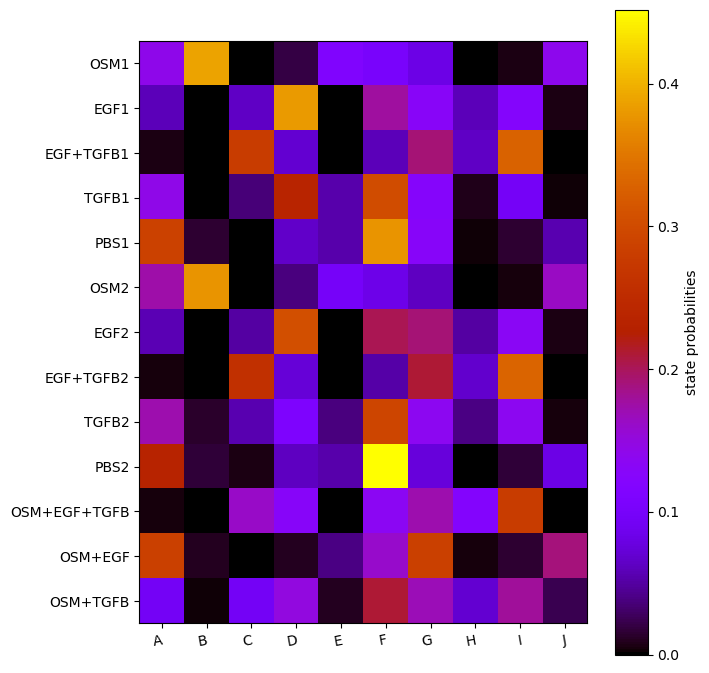

In [51]:
state_probs = np.zeros((num_trajModSet, n_states))
cell_states = clusters_minima
indstw = np.where(np.logical_and(indframes_traj < fu, indframes_traj > fl))[0]
for i in range(num_trajModSet):
    indstm = inds_conditions[i]
    indstwm = np.intersect1d(indstm, indstw)
    #x0 = embedTraj_feat[indstwm, :]
    x0 = Xpcat[indstwm, :]
    indc0 = stateSet[clusters_minima.assign(x0)]
    statesc, counts = np.unique(indc0, return_counts = True)
    state_probs[i, statesc] = counts/np.sum(counts)

state_order = np.arange(n_states).astype(int)

plt.clf()
plt.figure(figsize = (7, 7))
plt.imshow(state_probs[:, state_order], cmap=plt.cm.gnuplot)
cbar = plt.colorbar()
cbar.set_label('state probabilities')

# We want to show all ticks...
ax = plt.gca()
ax.set_yticks(np.arange(len(tmSet)))
ax.set_xticks(np.arange(nstates))
ax.set_xticklabels(np.array(state_labels)[state_order])
ax.set_yticklabels(tmSet)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=10, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.savefig('stateprobs_'+figid+'_nS_'+str(nstates)+'.png')
np.savetxt('stateprobs_'+figid+'_nS_'+str(nstates)+'.dat', state_probs[:, state_order])
plt.show()

<Figure size 640x480 with 0 Axes>

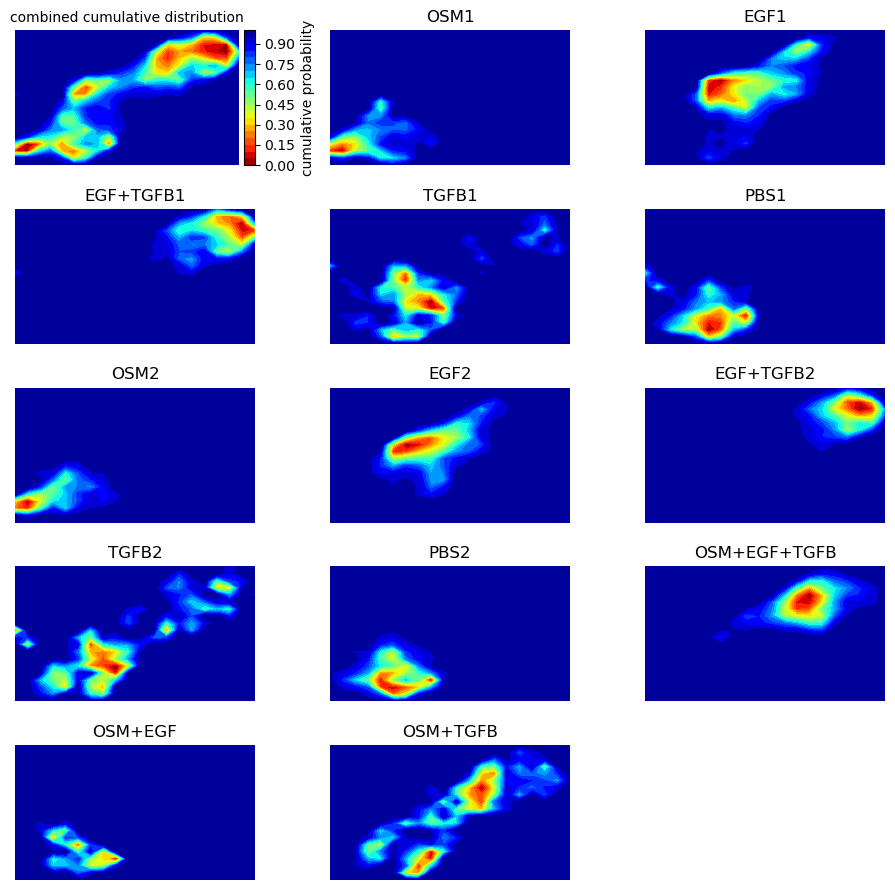

In [25]:
# Plot embedded probabilities for each condition and the cumulative one 
nbins = 20
probSet = [None]*nmodels
plt.clf()
plt.figure(figsize = (9, 9))
nRows_subplt = 5; nCols_subplt = 3
plt.subplot(nRows_subplt, nCols_subplt, 1) # Combined cumulative probability distribution over all models
prob1, xedges1, yedges1 = np.histogram2d(embedTraj_feat[indstw, 0], embedTraj_feat[indstw, 1],
                                         bins = nbins, density = True)
prob1c = get_cdist2d(prob1)
xx, yy = np.meshgrid(.5*xedges1[1:] + .5*xedges1[0:-1], .5*yedges1[1:] + .5*yedges1[0:-1])
levels = np.linspace(0, 1, 21)
cs = plt.contourf(xx, yy, prob1c.T, levels = levels, cmap = plt.cm.jet_r)
cbar = colorbar(cs)
cbar.set_label('cumulative probability')
plt.title('combined cumulative distribution', fontsize = 10)
plt.axis('off')
for imf in range(num_trajModSet):
    tm = tmSet[imf] # Trajectory model
    indstm = inds_conditions[imf]
    indstwm = np.intersect1d(indstm, indstw)
    indstwm = np.intersect1d(indstwm, indscc)
    plt.subplot(nRows_subplt, nCols_subplt, imf + 2) # Probability distribution of each condition
    prob, xedges2, yedges2 = np.histogram2d(embedTraj_feat[indstwm, 0], embedTraj_feat[indstwm, 1],
                                            bins = [xedges1, yedges1], density = True)
    #prob = prob/np.sum(prob)
    probc = get_cdist2d(prob)
    probSet[imf] = prob.copy() 
    #levels = np.linspace(0, np.max(prob), 100)
    cs = plt.contourf(xx, yy, probc.T, levels = levels, cmap = plt.cm.jet_r, extend = 'both')
    plt.title(tmSet[imf])
    cs.cmap.set_over('darkred')
    plt.axis('off')
    #plt.pause(.1)

plt.tight_layout()
plt.savefig('prob_'+figid+'.png')
plt.show()

In [ ]:
########### Plot probability flows ############
plt.clf()
plt.figure(figsize = (9, 9))
plt.subplot(nRows_subplt, nCols_subplt, 1)
plt.title('average')
ax = plt.gca()

for ic in range(n_clusters):
    ax.arrow(clusters.clustercenters[ic, 0], clusters.clustercenters[ic, 1], dxsav[ic, 0], dxsav[ic, 1], 
             head_width=.2, linewidth=.5, color='white', alpha=1.0)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.axis('off')

for i in range(num_trajModSet):
    indmodels = np.where(inds_tmSet_models == i)[0]
    dxf = np.mean(dxs[indmodels, :, :], axis=0)
    plt.subplot(nRows_subplt,nCols_subplt,i+2)
    ax = plt.gca()
    for ic in range(n_clusters):
        ax.arrow(clusters.clustercenters[ic, 0], clusters.clustercenters[ic, 1], dxf[ic, 0], dxf[ic, 1], 
                 head_width=.2, linewidth=.5, color='white', alpha=1.0)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.axis('off')
    plt.title(tmSet[i])
    plt.pause(.1)

plt.tight_layout()
plt.savefig('probflows_'+figid+'.png')

In [ ]:
############### Plot speed, alpha, cell-cell align, and cell-cell contact #################
vsetList = [Xpcat[:, -3], Xpcat[:, -2], Xpcat[:, -1], cb_ratio_traj]
captionset = ['speed','alpha','cellcell_align','cellcell_contact']
nbins = 20
for iv in range(len(vsetList)):
    vset = vsetList[iv]
    indg = np.where(np.logical_and(np.logical_not(np.isnan(vset)), np.logical_not(np.isinf(vset))))[0]
    plt.clf()
    plt.figure(figsize = (9, 9))
    plt.subplot(nRows_subplt, nCols_subplt, 1)
    vdist1, xedges1, yedges1 = np.histogram2d(embedTraj_feat[indg, 0], embedTraj_feat[indg, 1],
                                              bins=nbins, weights=vset[indg])
    norm1, xedges1, yedges1 = np.histogram2d(embedTraj_feat[indg, 0], embedTraj_feat[indg, 1], 
                                             bins=[xedges1, yedges1])
    vdist1 = np.divide(vdist1, norm1)
    indnan = np.where(np.isnan(vdist1))
    indgood = np.where(np.logical_and(np.logical_not(np.isnan(vdist1)), np.logical_not(np.isinf(vdist1))))
    xedges1c = .5*(xedges1[1:] + xedges1[0:-1])
    yedges1c = .5*(yedges1[1:] + yedges1[0:-1])
    xx, yy = np.meshgrid(xedges1c, yedges1c)
    levels = np.linspace(np.min(vdist1[indgood]), np.max(vdist1[indgood]), 20)
    cs = plt.contourf(xx, yy, vdist1.T, cmap=plt.cm.jet, levels=levels)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    for ic in range(n_clusters):
        ax = plt.gca()
        ax.arrow(clusters.clustercenters[ic, 0], clusters.clustercenters[ic, 1], dxsav[ic, 0], dxsav[ic, 1], 
                 head_width=.3, length_includes_head = True, width=.05, color='white', alpha=0.5)
    cs.cmap.set_over('darkred')
    cs.cmap.set_under('darkblue')
    cbar = colorbar(cs)
    cbar.set_label(captionset[iv])
    #cbar.set_label('cell-cell boundary fraction')
    #cbar.set_label('speed')
    #cbar.set_label('beta')
    plt.title('combined'+captionset[iv])
    plt.axis('off')
    plt.pause(3)
    #plt.tight_layout()
    #plt.savefig(captionset[iv]+'_flows_comb_'+figid+'.png')
    #plt.subplot(4,3,12)
    #cs = plt.contourf(xx,yy,vdist1.T,cmap=plt.cm.jet,levels=levels)
    #cs.cmap.set_over('darkred')
    #cs.cmap.set_under('darkblue')
    #plt.axis('off'); plt.title('combined')
    #plt.pause(.1)
    for i in range(num_trajModSet):
        plt.subplot(nRows_subplt, nCols_subplt, i + 2)
        indstm = inds_conditions[i]
        indstm = np.intersect1d(indg, indstm)
        vdist1, xedges1, yedges1 = np.histogram2d(embedTraj_feat[indstm, 0], embedTraj_feat[indstm, 1], 
                                                  bins=nbins, weights=vset[indstm])
        norm1, xedges1, yedges1 = np.histogram2d(embedTraj_feat[indstm, 0], embedTraj_feat[indstm, 1], 
                                                 bins=[xedges1, yedges1])
        vdist1 = np.divide(vdist1, norm1)
        indnan = np.where(np.isnan(vdist1))
        indgood = np.where(np.logical_and(np.logical_not(np.isnan(vdist1)), np.logical_not(np.isinf(vdist1))))
        cs = plt.contourf(xx, yy, vdist1.T, cmap=plt.cm.jet, levels=levels)
        cs.cmap.set_over('darkred')
        cs.cmap.set_under('darkblue')
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        plt.axis('off')
        plt.title(tmSet[i])
        plt.pause(.1)
    plt.tight_layout()
    plt.savefig(captionset[iv]+'_'+figid+'.png')

In [49]:
nbins = 100
indstw = np.where(np.logical_and(indframes_traj < fu, indframes_traj > fl))[0]
prob1, xedges1, yedges1 = np.histogram2d(embedTraj_feat[indstw, 0], embedTraj_feat[indstw, 1], 
                                         bins=nbins, density=True)
prob1 = prob1/np.sum(prob1)
prob1 = scipy.ndimage.gaussian_filter(prob1, sigma=2)
xx, yy = np.meshgrid(.5*xedges1[1:]+.5*xedges1[0:-1], .5*yedges1[1:]+.5*yedges1[0:-1])
probSet = [None]*num_trajModSet
for imf in range(num_trajModSet):
    indstm = inds_conditions[imf]
    indstwm = np.intersect1d(indstm, indstw)
    prob, xedges2, yedges2 = np.histogram2d(embedTraj_feat[indstwm, 0], embedTraj_feat[indstwm, 1], 
                                            bins=[xedges1, yedges1], density=True)
    prob = scipy.ndimage.gaussian_filter(prob, sigma=2)
    prob = prob/np.sum(prob)
    probSet[imf] = prob.copy()

In [50]:
plt.clf()
plt.figure(figsize = (7, 6))
nbins = 100
prob1, xedges1, yedges1 = np.histogram2d(embedTraj_feat[:, 0], embedTraj_feat[:, 1], bins=nbins, density=True)
prob1 = scipy.ndimage.gaussian_filter(prob1, sigma=2)
xx1, yy1 = np.meshgrid(.5*xedges1[1:]+.5*xedges1[0:-1], .5*yedges1[1:]+.5*yedges1[0:-1])
pts = np.array([xx1.flatten(), yy1.flatten()]).T
indpts = clusters_minima.assign(pts)
states = stateSet[indpts]
states = states[prob1.flatten() > np.min(prob1[prob1 > 0])]
pts = pts[prob1.flatten() > np.min(prob1[prob1 > 0]), :]
plt.contourf(xx1, yy1, prob1.T, cmap=plt.cm.gray_r, levels=20, alpha=.3)
plt.scatter(pts[:, 0], pts[:, 1], s=10, c=states, cmap=plt.cm.jet, marker='.', alpha=0.5)
plt.scatter(clusters_minima.clustercenters[:, 0], clusters_minima.clustercenters[:, 1],
            s = 100, c = stateSet, cmap = plt.cm.jet)

for istate in range(n_states):
    plt.text(state_centers_minima[istate, 0], state_centers_minima[istate, 1], str(state_labels[istate]))

plt.pause(.1)
plt.tight_layout()
plt.savefig('kineticstates_'+figid+'_nS_'+str(nstates)+'.png')

ValueError: dimension mismatch centers and provided data to assign.

<Figure size 640x480 with 0 Axes>

<Figure size 700x600 with 0 Axes>

In [ ]:
states_x = stateSet[cell_states.assign(embedTraj_feat)]
inds_states = [None]*n_states
for i in range(n_states):
    indstate = np.where(states_x == i)[0]
    inds_states[i] = indstate

vset = Xpcat[:, -3]

plt.clf()
plt.figure(figsize = (8, 7))
ax = plt.gca()

for i in range(n_states):
    ii = state_order[i]
    vplot = ax.violinplot(vset[inds_states[ii]], positions=[i+1], 
                          showmeans=True, showextrema=False) # quantiles=[.05,.95])
    vplot['cmeans'].set_color('black')
    for pc in vplot['bodies']:
        pc.set_facecolor('black')
        #pc.set_edgecolor('black')
        #pc.set_alpha(1)
    plt.pause(.1)

ax.set_xticks(range(1, n_states + 1))
ax.set_xticklabels(np.array(state_labels)[state_order])
#plt.ylabel('log2(nuc/cyto cc-ratio)')
#plt.ylabel(r'cell-cell local alignment $\langle \hat{v}_1 \cdot \hat{v}_2 \rangle$')
#plt.ylabel('speed (z-score)')
plt.ylabel('speed (z-score)')
plt.xlabel('states')
plt.pause(.1)
plt.tight_layout()
plt.savefig('speed_'+figid+'.png')

In [ ]:
from adjustText import adjust_text

plt.clf()
istate = 3
indcells_traj = inds_states[istate]
indmodels = indtreatment_traj[indcells_traj]
indcells_model = cellinds1_traj[indcells_traj]
#for ic in [50, 100, 150, 200]: # range(indcells_traj.size)
for ic in range(0, indcells_traj.size, 50):
    celltraj = self.get_cell_trajectory(indcells_model[ic])
    self.visual = True
    self.show_cells(celltraj)
    plt.pause(1)
    plt.tight_layout()
    plt.savefig('cell'+str(ic)+'_state'+str(istate)+'_'+figid+'.png')

In [ ]:
from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score
nstates_initial = nstates_initial
def get_kineticstates(self, nstates_initial, P = None, clusters_minima = None,
                      pcut_final = 0.01, random_state = 0, ncomp = 15):
    if P is None:
        print('input transition matrix')
        return
    if clusters_minima is None:
        clusters_minima = self.clusterst
    stateCenters = clusters_minima.clustercenters
    nstates_good = 0
    nstates = nstates_initial
    #silhouette_scores = []
    #nClusters = []
    #plt.clf()
    #plt.figure(figsize = (6, 5))
    while nstates_good < nstates_initial and nstates < 5*nstates_initial: 
        H = .5*(P + np.transpose(P)) + .5j*(P - np.transpose(P))
        w, v = np.linalg.eig(H) # Find Eigen Values and Eigen vectors of transition matrix 
        w = np.real(w)
        indsort = np.argsort(w)
        w = w[indsort] # Eigen Values
        v = v[:, indsort] # Eigen Vectors
        vr = np.multiply(w[-ncomp:], np.real(v[:, -ncomp:]))
        vi = np.multiply(w[-ncomp:], np.imag(v[:, -ncomp:]))
        vkin = np.append(vr, vi, axis=1)
        ############################ KMeans from deeptime #########################
        #clusters_v = KMeans(n_clusters=nstates, init_strategy='kmeans++', max_iter=1000).fit(vkin).fetch_model()
        #stateSet = clusters_v.transform(vkin)
        ############################ KMeans from sklearn ##########################
        clusters_v = KMeans(n_clusters = nstates, init = 'k-means++', n_init = 20000, max_iter = 1000)
        clusters_v.fit(vkin)
        stateSet = clusters_v.labels_
        ######### Examine how many n_clusters aka nstates better represent ########
        #labels_s = clusters_v.predict(vkin)
        #score = silhouette_score(vkin, labels_s)
        #silhouette_scores.append(score)
        state_center_minima = np.zeros((nstates, neigen))
        for i in range(nstates):
            indstate = np.where(stateSet == i)[0]
            state_center_minima[i, :] = np.mean(clusters_minima.clustercenters[indstate, :], axis=0)
        state_probs = np.zeros((num_trajModSet, nstates))
        for i in range(num_trajModSet):
            indstm = inds_conditions[i]
            #x0 = embedTraj_feat[indstm, :]
            x0 = Xpcat[indstm, :]
            indc0 = stateSet[clusters_minima.assign(x0)]
            statesc, counts = np.unique(indc0, return_counts=True)
            state_probs[i, statesc] = counts/np.sum(counts)
        state_tprobs = np.sum(state_probs, axis=0)/num_trajModSet
        print("Transition probabilities of", nstates, "states: ",np.sort(state_tprobs))
        # nstates_good: If transition probabilities of cell states are higher than set probability cutoff
        nstates_good = np.sum(state_tprobs > pcut_final)
        print(nstates, "initial states,", nstates_good, "final (Good) states")
        #nClusters.append(nstates)
        nstates = nstates + 1
    pcut = np.sort(state_tprobs)[-(nstates_initial)] # nstates
    states_plow = np.where(state_tprobs < pcut)[0] # states with low probabilities
    ################# Remove/clean states with low probabilities ####################
    for i in states_plow:
        indstate = np.where(stateSet == i)[0]
        for imin in indstate:
            dists = wctm.get_dmat(np.array([stateCenters[imin, :]]), stateCenters)[0]
            dists[indstate] = np.inf
            ireplace = np.argmin(dists)
            stateSet[imin] = stateSet[ireplace]
    slabels, counts = np.unique(stateSet, return_counts=True)
    s = 0
    stateSet_clean = np.zeros_like(stateSet)
    for slabel in slabels:
        indstate = np.where(stateSet == slabel)[0]
        stateSet_clean[indstate] = s
        s = s + 1
    stateSet = stateSet_clean
    """
    # Plot Silhouette Scores 
    plt.plot(nClusters, silhouette_scores)
    plt.title('Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')
    plt.tight_layout()
    plt.savefig('silhouette_scores_'+figid+'_'+str(nstates)+'.png') 
    """
    return stateSet, nstates

In [ ]:
get_kstates = True
stateCenters = clusters_minima.clustercenters

if get_kstates:
    stateSet, nstates = get_kineticstates(wctm, nstates_initial, P=P, 
                                          clusters_minima = clusters_minima, pcut_final=.02)
    objFile = 'stateSet_'+figid+'_nS'+str(nstates)+'.joblib'
    states_object = [clusters_minima, stateSet]
    with open(objFile, 'wb') as fpStates:
        dump(states_object, fpStates, compress = 'zlib')
else:
    objFile = 'stateSet_'+figid+'_nS'+str(nstates_initial)+'.joblib'
    with open(objFile, 'rb') as fpStates:
        states_object = load(fpStates)
    clusters_minima = states_object[0]
    stateSet = states_object[1]